<a href="https://colab.research.google.com/github/Chiwidude/ETL-EstimadorRiesgo/blob/dscience/ETLv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparación de Entorno**

In [48]:
!pip install -U scikit-learn
!pip install scikit-learn-intelex
!pip install -U imbalanced-learn
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.2 MB/s 
     |████████████████████████████████| 199 kB 45.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install Pyspatialml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.6 MB/s 
     |████████████████████████████████| 1.0 MB 40.2 MB/s 
     |████████████████████████████████| 19.3 MB 12.7 MB/s 
     |████████████████████████████████| 16.7 MB 4.4 MB/s 
     |████████████████████████████████| 6.3 MB 21.4 MB/s 


# Conjuntos de datos variables independientes

In [54]:
from pyspatialml import Raster
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

In [4]:
lsd_df = gpd.read_file("drive/MyDrive/Tesis/deslizamientos/desli_lim.shp")

files = ["drive/MyDrive/Tesis/raster_curvatura/curvatura_r.tif","drive/MyDrive/Tesis/raster_elevacion/elevacion_r.tif","drive/MyDrive/Tesis/raster_pendiente/pendiente_r.tif","drive/MyDrive/Tesis/raster_perfil_curvatura/perfilc_r.tif",
         "drive/MyDrive/Tesis/raster_lluvia/lluvia_r.tif","drive/MyDrive/Tesis/raster_cobertura/cobertura_r.tif"]
rasters =Raster(files)

In [5]:
raster_desli = rasterio.open('drive/MyDrive/Tesis/deslizamientos/raster/desli_lim.tif')

In [6]:
rasters.bounds

BoundingBox(left=323388.7577661315, bottom=1589357.1699691617, right=508688.7577661315, top=1777837.1699691617)

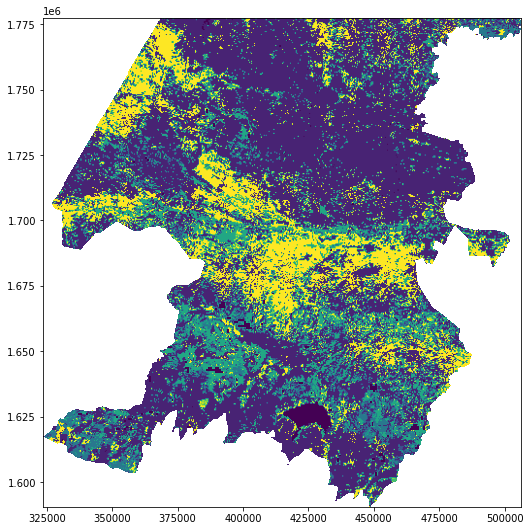

In [7]:
fig, ax = plt.subplots(figsize=(9, 9))

rasters.cobertura_r.plot(ax=ax)
rasterio.plot.show(raster_desli, ax=ax)
plt.show()

In [8]:
extracted_df = rasters.extract_raster(raster_desli)

extracted_df.dropna(inplace=True)
extracted_df

,value,curvatura_r,elevacion_r,pendiente_r,perfilc_r,lluvia_r,cobertura_r,geometry
0,0.0,0.50,1621.0,9.800000,0.473218,2392.033447,2.0,POINT (369009.824 1777200.007)
1,0.0,0.75,1574.0,20.196274,0.687335,2648.619141,2.0,POINT (373376.451 1777200.007)
2,0.0,1.00,1640.0,2.977056,1.483140,2869.323730,2.0,POINT (378470.851 1777200.007)
3,0.0,0.75,594.0,21.701746,-3.096038,2679.779541,2.0,POINT (404670.618 1777200.007)
4,0.0,0.25,391.0,22.294275,0.006878,2923.886230,2.0,POINT (417770.501 1777200.007)
...,...,...,...,...,...,...,...,...
6159,0.0,1.25,894.0,11.518590,-0.665087,2843.120117,7.0,POINT (451247.982 1594529.407)
6160,0.0,0.50,820.0,1.662445,-0.142286,3109.098877,7.0,POINT (449792.439 1593801.636)
6162,0.0,0.25,767.0,6.109069,0.095966,3204.624512,2.0,POINT (449064.668 1593073.865)
6163,0.0,0.50,779.0,2.679327,0.239556,3208.293701,7.0,POINT (449792.439 1593073.865)


# Pipeline Ciencia de Datos (ML)

In [56]:
#Data Spliting inicial
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE

X = extracted_df.drop(columns=['value','geometry']).values

Y = extracted_df['value'].values

smote = BorderlineSMOTE(random_state=30, n_jobs=-1)

X_smote, Y_smote = smote.fit_resample(X,Y)

x_train, x_test, y_train, y_test = train_test_split(X_smote,Y_smote,test_size=0.3, random_state=30)

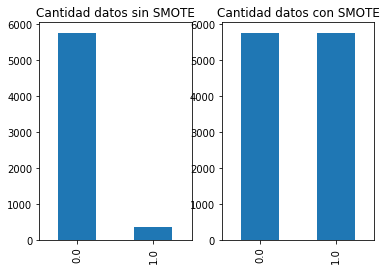

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2)
extracted_df['value'].value_counts().plot(kind='bar', ax=axes[0])
pd.Series(Y_smote).value_counts().plot(kind='bar', ax=axes[1])

axes[0].set_title('Cantidad datos sin SMOTE')
axes[1].set_title('Cantidad datos con SMOTE')
plt.show()

## Random Forest

In [68]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import numpy as np

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [59]:

#Encontrar los hiperparámetros más adecuados para el modelo
base_classifier = RandomForestClassifier()

n_estimators = np.linspace(100,3000,int((3000-100)/200)+1, dtype=int)

max_features = ['sqrt','log2']

max_depth = [1,5,10,20,50,100, None]

min_samples_split = [1, 2, 5, 10, 15, 20, 30]

min_samples_leaf = [1, 2, 3, 4]

criterion=['gini', 'entropy']


params_grid = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'criterion':criterion}

rf_sampled = RandomizedSearchCV(estimator=base_classifier,
                                param_distributions=params_grid,
                                n_iter=30, cv=5, verbose=2, n_jobs = -1,
                                random_state=42
                                )


rf_sampled.fit(x_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 100,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [60]:
rf_sampled.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1757}

In [69]:
classifier = RandomForestClassifier(**rf_sampled.best_params_)
rf = Pipeline(
    [('scaling', StandardScaler()),
        ('classifier', classifier)])

In [62]:
scores = cross_validate(
    estimator=rf,
    X=x_test,
    y=y_test,
    scoring="accuracy"
)

scores['test_score'].mean()

0.9048886174849219

In [71]:
rf.fit(x_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        max_features='log2',
                                        n_estimators=1757))])

In [ ]:
result_rf = rasters.predict(estimator=rf, progress=True)

#result_probs = rasters.predict_proba(estimator=rf)

 61%|██████    | 833/1369 [2:28:27<1:55:37, 12.94s/it]

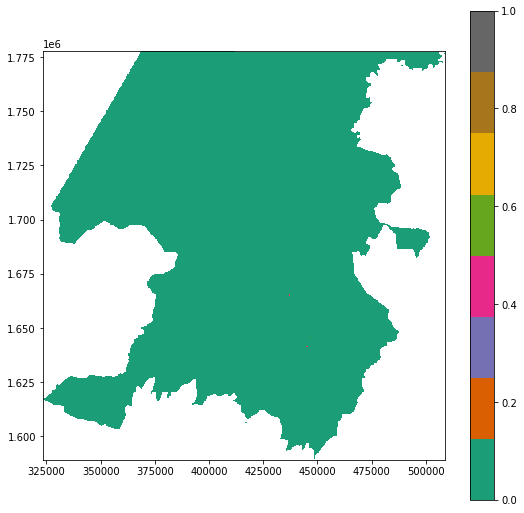

In [46]:
fig, ax = plt.subplots(figsize=(9, 9))

result_rf.iloc[0].cmap = "Dark2"
result_rf.iloc[0].categorical = True
result_rf.iloc[0].plot(ax=ax, legend=True)
plt.show()

In [47]:
df = result_rf.to_pandas()

df.pred_raw_0.value_counts()

0.0    52145544
1.0        1408
Name: pred_raw_0, dtype: int64

## Support Vector Machine

In [ ]:
from sklearn import svm

In [28]:
X = extracted_df.drop(columns=['value','geometry']).values

Y = extracted_df['value'].values

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30)

param_grid = {'C': [0.01, 0.1, 1], 
              'gamma': [1, 0.75, 0.5], 
              'kernel': ['rbf', 'poly', 'linear'],
              'cache_size':[600,1000]}
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=1, cv=5, n_jobs=-1)

grid.fit(x_train, y_train)

best_params = grid.best_params_

best_params 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: ignored

In [20]:
svmc = svm.SVC(probability=True, C=0.8, cache_size=2000, random_state=30)

svc = Pipeline(
    [('scaling', StandardScaler()),
        ('classifier', svmc)])

svc.fit(x_train, y_train)

Pipeline(steps=[('scaling', StandardScaler()),
                ('classifier',
                 SVC(C=0.8, cache_size=2000, probability=True,
                     random_state=30))])

In [21]:
scores = cross_validate(
    estimator=svc,
    X=x_test,
    y=y_test,
    scoring="accuracy"
)

scores['test_score'].mean()

0.9444897959183673

In [22]:
result = rasters.predict(estimator=svc, progress=True)

#result_probs = rasters.predict_proba(estimator=svc)

100%|█████████▉| 1368/1369 [04:49<00:00,  4.73it/s]


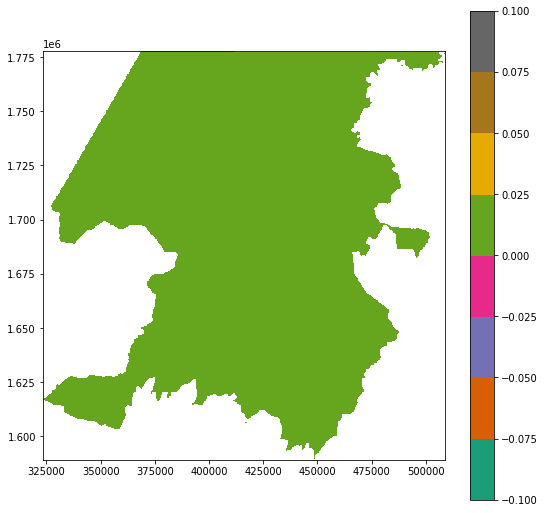

In [23]:
fig, ax = plt.subplots(figsize=(9, 9))

result.iloc[0].cmap = "Dark2"
result.iloc[0].categorical = True
result.pred_raw_0.plot(ax=ax, legend=True)
plt.show()

In [ ]:
df = result.to_pandas()

df.pred_raw_0.value_counts()

0.0    52146952
Name: pred_raw_0, dtype: int64